#Segmentacja obrazów dna oka
* Inspiracja: https://github.com/karolzak/keras-unet/blob/master/notebooks/kz-isbi-challenge.ipynb
* Dostosowany do aktualnej wersji Keras-a


# Podpięcie Google Drive
Colab musi mieć dostęp do dysku -- należy udzielić zgody.

In [ ]:
from google.colab import drive
drive.mount('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [ ]:
def my_path(p):
  BASE_PATH = '/content/gdrive/MyDrive/colab-iwm'
  return f"{BASE_PATH}/{p}"

# Przygotowanie danych

### Pobranie i rozpakowanie obrazów z bazy HRF
https://www5.cs.fau.de/research/data/fundus-images/

In [ ]:
# Fundus
!wget https://www5.cs.fau.de/fileadmin/research/datasets/fundus-images/healthy.zip
!wget https://www5.cs.fau.de/fileadmin/research/datasets/fundus-images/glaucoma.zip
!wget https://www5.cs.fau.de/fileadmin/research/datasets/fundus-images/diabetic_retinopathy.zip

# FOV
!wget  https://www5.cs.fau.de/fileadmin/research/datasets/fundus-images/healthy_fovmask.zip
!wget  https://www5.cs.fau.de/fileadmin/research/datasets/fundus-images/glaucoma_fovmask.zip
!wget  https://www5.cs.fau.de/fileadmin/research/datasets/fundus-images/diabetic_retinopathy_fovmask.zip

# Masks
!wget  https://www5.cs.fau.de/fileadmin/research/datasets/fundus-images/healthy_manualsegm.zip
!wget  https://www5.cs.fau.de/fileadmin/research/datasets/fundus-images/glaucoma_manualsegm.zip
!wget  https://www5.cs.fau.de/fileadmin/research/datasets/fundus-images/diabetic_retinopathy_manualsegm.zip

--2022-04-29 09:03:44--  https://www5.cs.fau.de/fileadmin/research/datasets/fundus-images/healthy.zip
Resolving www5.cs.fau.de (www5.cs.fau.de)... 131.188.35.25
Connecting to www5.cs.fau.de (www5.cs.fau.de)|131.188.35.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19295899 (18M) [application/zip]
Saving to: ‘healthy.zip’

healthy.zip         100%[===================>]  18.40M  14.8MB/s    in 1.2s    

2022-04-29 09:03:46 (14.8 MB/s) - ‘healthy.zip’ saved [19295899/19295899]

--2022-04-29 09:03:46--  https://www5.cs.fau.de/fileadmin/research/datasets/fundus-images/glaucoma.zip
Resolving www5.cs.fau.de (www5.cs.fau.de)... 131.188.35.25
Connecting to www5.cs.fau.de (www5.cs.fau.de)|131.188.35.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21732825 (21M) [application/zip]
Saving to: ‘glaucoma.zip’

glaucoma.zip        100%[===================>]  20.73M  16.5MB/s    in 1.3s    

2022-04-29 09:03:47 (16.5 MB/s) - ‘glaucoma.zip’ save

In [ ]:
# Utworzenie katalogów na oryginalne i przeskalowane (zmniejszone) obrazy
!mkdir -p /content/gdrive/MyDrive/colab-iwm/data/hrf/full/{fundus,fov,mask}
!mkdir -p /content/gdrive/MyDrive/colab-iwm/data/hrf/resized/{fundus,fov,mask}


In [ ]:
# Rozpakowanie plikoów

# Fundus
!unzip healthy.zip -d /content/gdrive/MyDrive/colab-iwm/data/hrf/full/fundus
!unzip glaucoma.zip -d /content/gdrive/MyDrive/colab-iwm/data/hrf/full/fundus
!unzip diabetic_retinopathy.zip -d /content/gdrive/MyDrive/colab-iwm/data/hrf/full/fundus

# FOV
!unzip healthy_fovmask.zip -d /content/gdrive/MyDrive/colab-iwm/data/hrf/full/fov
!unzip glaucoma_fovmask.zip -d /content/gdrive/MyDrive/colab-iwm/data/hrf/full/fov
!unzip diabetic_retinopathy_fovmask.zip -d /content/gdrive/MyDrive/colab-iwm/data/hrf/full/fov

# Masks
!unzip healthy_manualsegm.zip -d /content/gdrive/MyDrive/colab-iwm/data/hrf/full/mask
!unzip glaucoma_manualsegm.zip -d /content/gdrive/MyDrive/colab-iwm/data/hrf/full/mask
!unzip diabetic_retinopathy_manualsegm.zip -d /content/gdrive/MyDrive/colab-iwm/data/hrf/full/mask

Archive:  healthy.zip
  inflating: /content/gdrive/MyDrive/Colab/data/hrf/full/fundus/01_h.jpg  
  inflating: /content/gdrive/MyDrive/Colab/data/hrf/full/fundus/02_h.jpg  
  inflating: /content/gdrive/MyDrive/Colab/data/hrf/full/fundus/03_h.jpg  
  inflating: /content/gdrive/MyDrive/Colab/data/hrf/full/fundus/04_h.jpg  
  inflating: /content/gdrive/MyDrive/Colab/data/hrf/full/fundus/05_h.jpg  
  inflating: /content/gdrive/MyDrive/Colab/data/hrf/full/fundus/06_h.jpg  
  inflating: /content/gdrive/MyDrive/Colab/data/hrf/full/fundus/07_h.jpg  
  inflating: /content/gdrive/MyDrive/Colab/data/hrf/full/fundus/08_h.jpg  
  inflating: /content/gdrive/MyDrive/Colab/data/hrf/full/fundus/09_h.jpg  
  inflating: /content/gdrive/MyDrive/Colab/data/hrf/full/fundus/10_h.jpg  
  inflating: /content/gdrive/MyDrive/Colab/data/hrf/full/fundus/11_h.jpg  
  inflating: /content/gdrive/MyDrive/Colab/data/hrf/full/fundus/12_h.jpg  
  inflating: /content/gdrive/MyDrive/Colab/data/hrf/full/fundus/13_h.jpg  
  i

In [ ]:
# Poprawienie nazw plików (wszystkie rozszerzenia małymi literami)
!find /content/gdrive/MyDrive/colab-iwm/data/hrf/full/fundus/ -depth -name "*.JPG" -exec sh -c 'f="{}"; mv -- "$f" "${f%.JPG}.jpg"' \;

### Przeskalowanie obrazów
Zmniejszenie obrazu i dopasowanie wymiaru do wymagań U-Net-a (oba wymiary podzielne przez 16)

In [ ]:
import numpy as np
from os import listdir, path
from skimage import io, transform
from math import ceil

In [5]:
def resize_image(img):
  PAD_WIDTH = [(112,), (40, ), (0, )]
  is_color = len(img.shape) > 2
  padded_img = np.pad(img, PAD_WIDTH if is_color else PAD_WIDTH[:2], 'constant')
  SCALE = 0.125 # było 0.25
  return  transform.rescale(padded_img, 0.125, multichannel=is_color)


In [ ]:
!pip install imagecodecs

In [8]:
import imagecodecs
from os import listdir, path

# folders = ['fundus', 'fov', 'mask']
folders = ['fov', 'mask']
for f in folders:
  src_dir = my_path(f"data/hrf/full/{f}")
  dest_dir = my_path(f"data/hrf/resized/{f}")
  for src_fn in listdir(src_dir):
    src_path = f"{src_dir}/{src_fn}"
    full_img = io.imread(src_path)
    if (f == 'fov'):
      full_img = full_img[:, :, 0]
    resized_img = resize_image(full_img)
    dest_fn = path.splitext(src_fn)[0].replace("_mask", "") + ".png"
    dest_path = f"{dest_dir}/{dest_fn}"
    print(f"{dest_path} {resized_img.shape}")
    io.imsave(f"{dest_path}", (resized_img*255).astype(np.uint8)))

SyntaxError: unmatched ')' (2097748991.py, line 18)

### Instalacja `keras-unet`

In [ ]:
!pip install keras-unet

In [ ]:
import keras_unet

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


### Odczyt i wizualiacja przeskalowanych obrazów



In [ ]:
from skimage.io import ImageCollection, imread
from skimage.exposure import rescale_intensity
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def imread_convert(f):
  return rescale_intensity(imread(f), out_range=((0, 1)))

img_ic = ImageCollection(my_path('data/hrf/resized/fundus/*.png'), load_func=imread_convert)
mask_ic = ImageCollection(my_path('data/hrf/resized/mask/*.png'), load_func=imread_convert)


In [ ]:
# Przygotowujemy dane - konwencja nazw jak w scikitlearn: X - obrazy, y - maski
X = img_ic.concatenate()
y = mask_ic.concatenate()
y = y.reshape(y.shape + (1,))

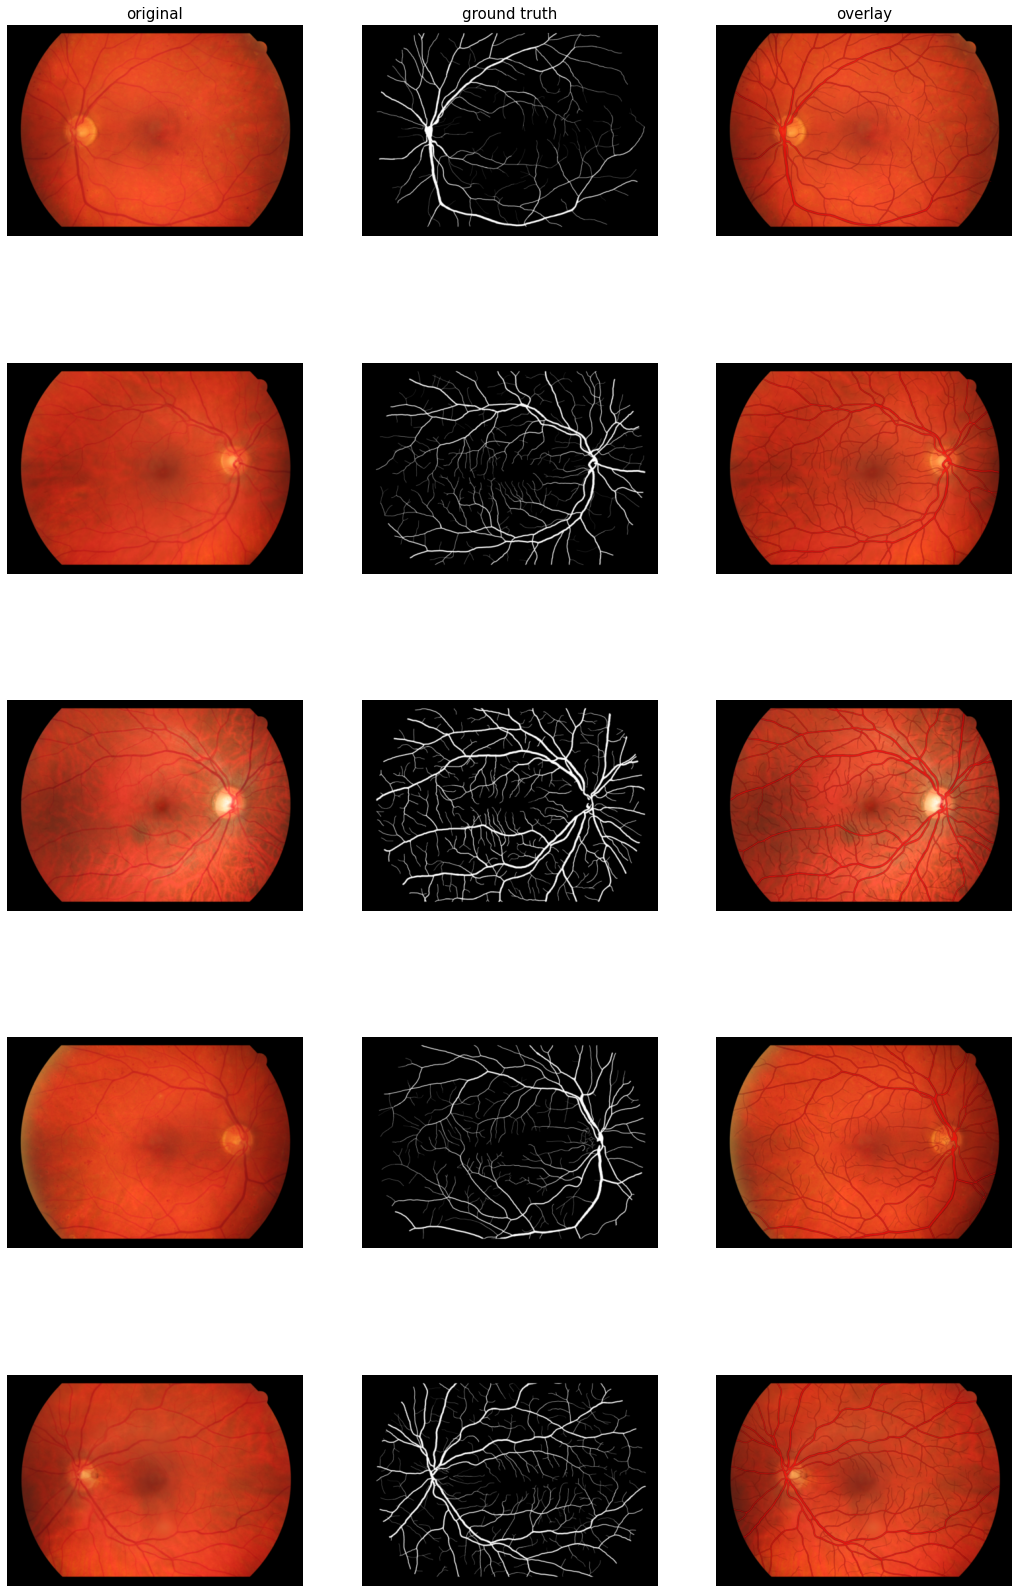

In [ ]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X, mask_imgs=y, nm_img_to_plot=5, figsize=6)

### Podział danych na część uczącą i walidującą (testującą)
10 obrazów w zbiorze walidacyjnym, pozostałe w zbiorze uczącym

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=10, random_state=42)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)

X_train:  (35, 320, 448, 3)
y_train:  (35, 320, 448, 1)
X_val:  (10, 320, 448, 3)
y_val:  (10, 320, 448, 1)


# Przygotowanie sieci

### Przygotowanie generatora
Zastosowanie augmentacji w celu zwiększenia ilości danych uczących poprzed wprowadzenie zaburzeń (obrót, przesunięcie, odwrócenie, itp.) do istniejących zdjęć

In [ ]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

(2, 320, 448, 3) (2, 320, 448, 1)


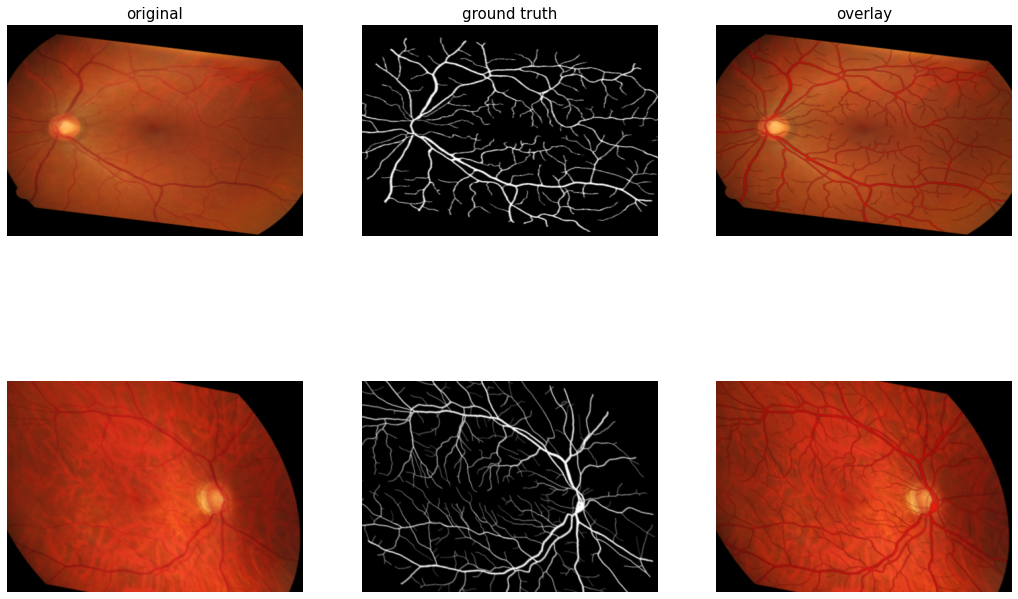

In [ ]:
sample_batch = next(train_gen)
X_aug, y_aug = sample_batch
print(X_aug.shape, y_aug.shape)

from keras_unet.utils import plot_imgs
plot_imgs(org_imgs=X_aug, mask_imgs=y_aug, nm_img_to_plot=2, figsize=6)

### Inicjalizacja sieci

In [ ]:
# Rozmiar przetwarzanych obrazów (łącznie z kolorami)
input_shape = (None, None, 3)

In [ ]:
from keras_unet.models import custom_unet

model = custom_unet(
    input_shape,
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_19 (Conv2D)             (None, None, None,   1792        ['input_2[0][0]']                
                                64)                                                               
                                                                                                  
 spatial_dropout2d_5 (SpatialDr  (None, None, None,   0          ['conv2d_19[0][0]']              
 opout2D)                       64)                                                         

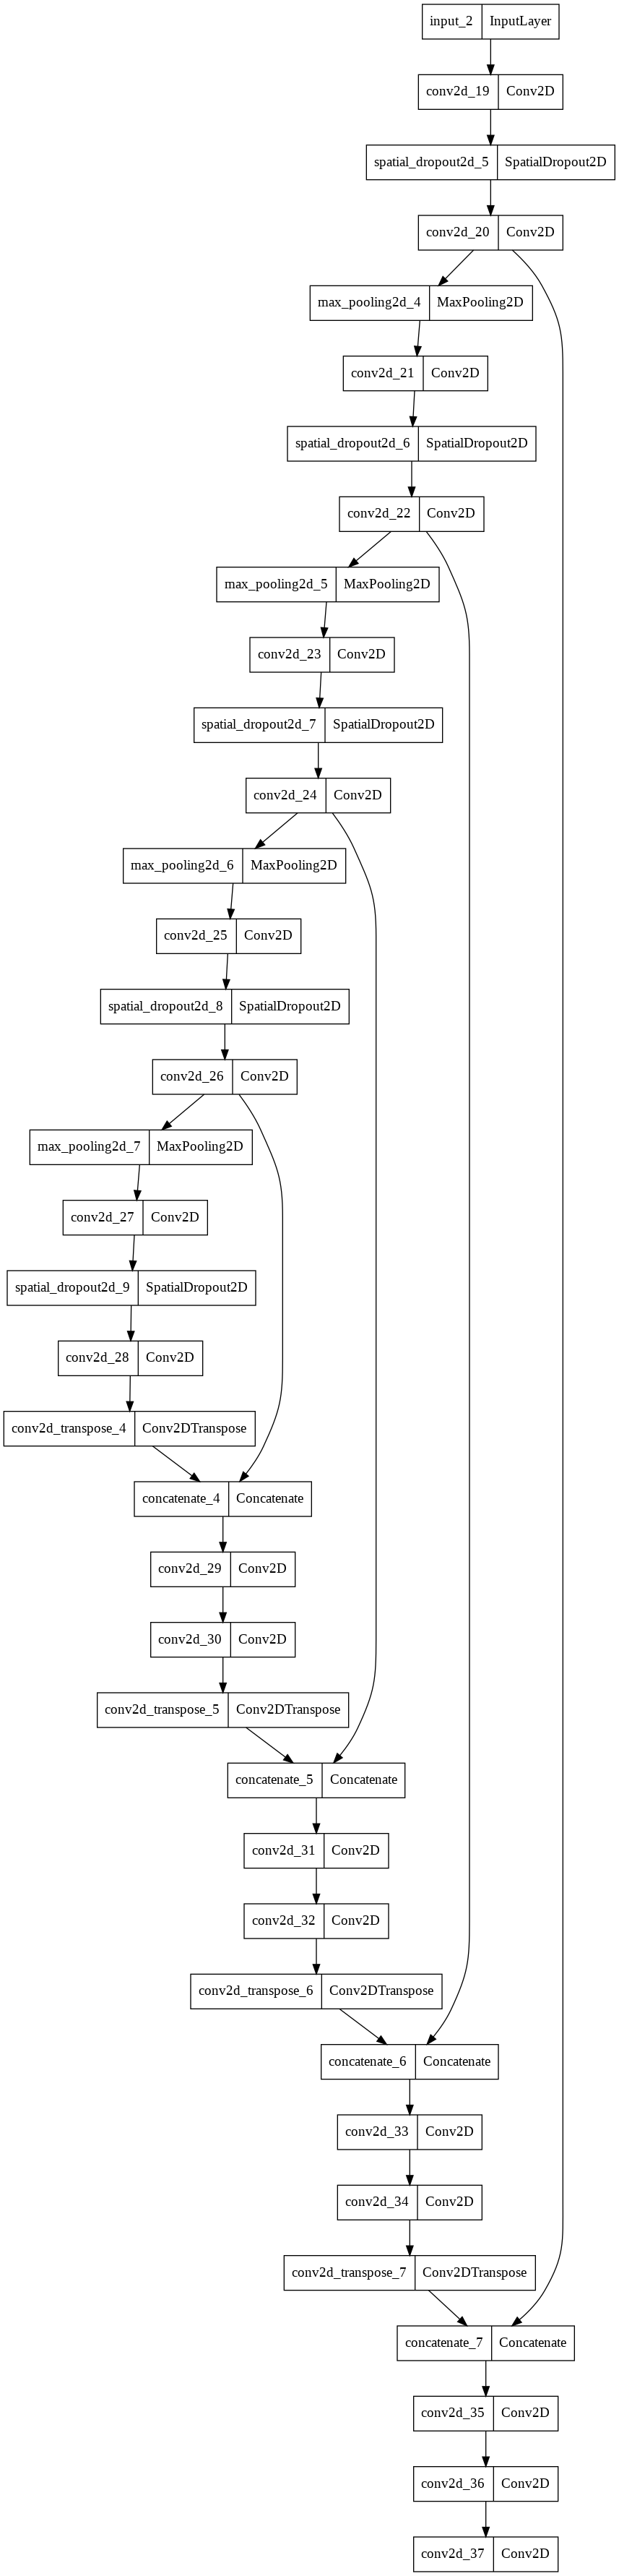

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file=my_path('model/unet-model.png'))

## Trenowanie i testowanie sieci

In [ ]:
from keras.callbacks import ModelCheckpoint


model_fn = my_path('model/fundus.h5')
callback_checkpoint = ModelCheckpoint(
    model_fn,
    verbose=1,
    monitor='val_loss',
    save_best_only=True,
)

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

model.compile(
    # optimizer=Adam(),
    optimizer=SGD(learning_rate=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou, iou_thresholded]
)

In [ ]:
history = model.fit(
    train_gen,
    steps_per_epoch=100,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[callback_checkpoint]
)

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.1508 - iou: 0.2417 - iou_thresholded: 0.3149
Epoch 1: val_loss did not improve from 0.13820
100/100 [==============================] - 26s 242ms/step - loss: 0.1508 - iou: 0.2417 - iou_thresholded: 0.3149 - val_loss: 0.1405 - val_iou: 0.2848 - val_iou_thresholded: 0.4200
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.1587 - iou: 0.2197 - iou_thresholded: 0.2788
Epoch 2: val_loss did not improve from 0.13820
100/100 [==============================] - 24s 241ms/step - loss: 0.1587 - iou: 0.2197 - iou_thresholded: 0.2788 - val_loss: 0.1443 - val_iou: 0.2645 - val_iou_thresholded: 0.3667
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.1636 - iou: 0.2186 - iou_thresholded: 0.2842
Epoch 3: val_loss did not improve from 0.13820
100/100 [==============================] - 24s 244ms/step - loss: 0.1636 - iou: 0.2186 - iou_thresholded: 0.2842 - val_loss: 0.1544 - val_iou: 0.208

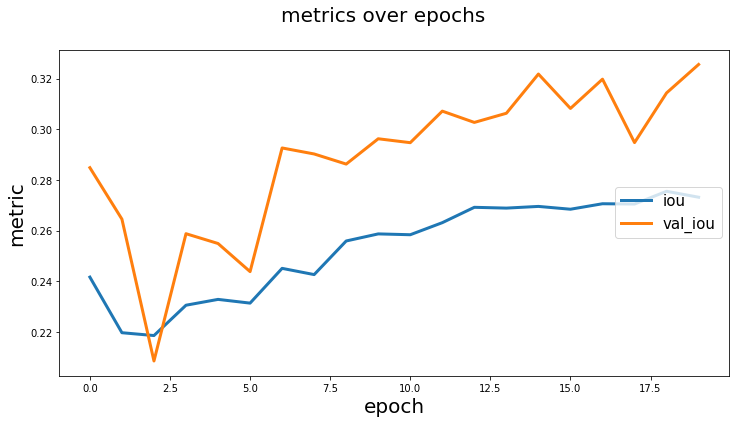

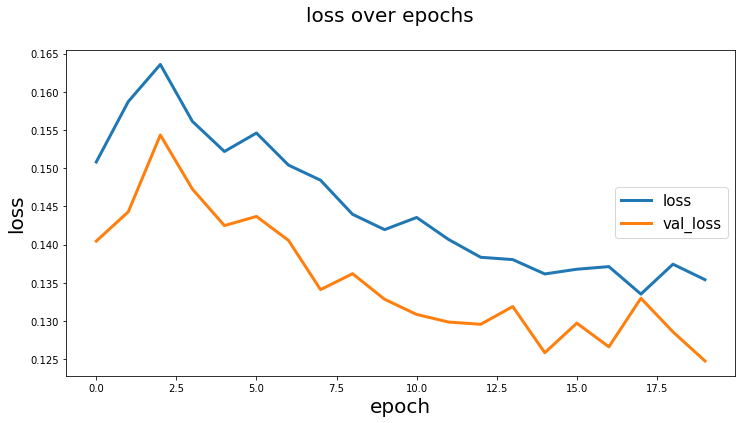

In [ ]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

# Wykorzystanie sieci do danych testowych

In [ ]:
model_fn = my_path('model/fundus.h5')

In [ ]:
model.load_weights(model_fn)
y_pred = model.predict(X_val)

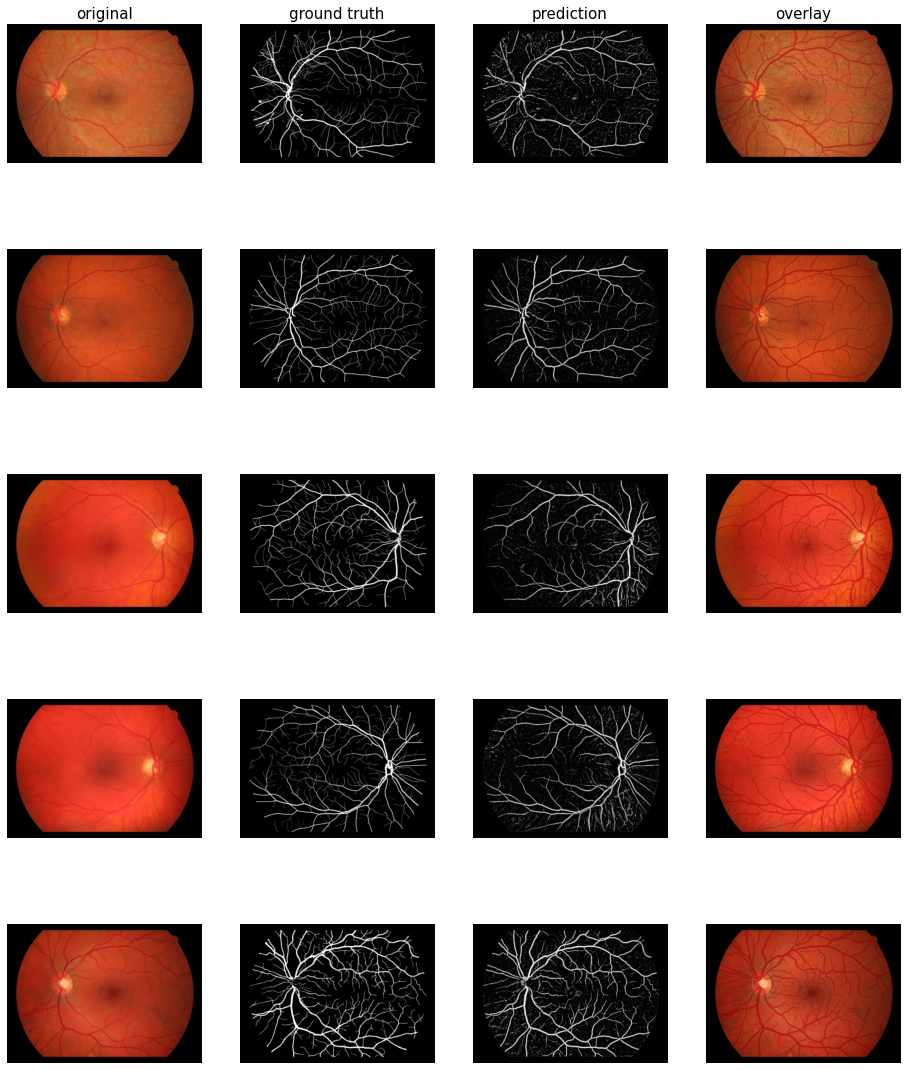

In [ ]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=5)

In [ ]:
# Zapis wygenerowanych masek do pliku
y_pred.shape

(10, 320, 448, 1)

In [ ]:
from skimage import io
from skimage.exposure import rescale_intensity
from skimage.util import img_as_ubyte

def convert_imsave(file_name, img):
  io.imsave(file_name, img_as_ubyte(rescale_intensity(img, out_range=(0, 255)).astype(np.uint8)))

for i in range(y_pred.shape[0]):
  convert_imsave(my_path(f"eval/{i + 1}-y-true.png"), y_val[i])
  convert_imsave(my_path(f"eval/{i + 1}-y-pred-{i + 1}.png"), y_pred[i])
  convert_imsave(my_path(f"eval/{i + 1}-X.png"), X_val[i])